In [1]:
# imports
import numpy as np
import random
import math
import timeit
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
# Read data functions
def string_to_spin(string):
    """
    Convert string of 0 and 1 to a np array of spins (-1, 1):
    0 -> -1
    1 -> +1
    :param string: String: original string.
    :return: np.array: Spins.
    """
    return (np.array(list(map(int, list(string)))) * 2 - 1)

def read_configurations(name, n):
    """
    Reads a file and returns a np array with the spin configuration.
    :param name: String: Name of the file.
    :param n: Int: Number of spins.
    :return: np.array: Matrix of shape (Data_number, num_spins).
    """
    spins = np.array([])
    filepath = name
    with open(filepath, 'r') as fp:
        s = fp.readlines()  
    spins = np.array([string_to_spin(e.rstrip()) for e in s]).flatten()
    return np.reshape(spins, (int(len(spins)/n), n)).astype('int')

def read_j_coef(name, n):
    """
    Reads a file and returns a np array with the j coefficients.
    :param name: String: Name of the file.
    :param n: Int: Number of spins.
    :return: np.array: Array of shape 2*n.
    """
    j = np.zeros((n, 2))
    filepath = name
    with open(filepath) as fp:
        for line in tqdm_notebook(fp.readlines()):
            list_line = line.split()
            if len(list_line) == 2:
                el = list_line[-1]
                list_line[-1] = el[0]
                list_line.append(el[1:])
            s = int(list_line[0])-1
            d = int(list_line[1])-1
            # list line té 3 llocs: numspin, (1 o 2) i el valor de J
            j[s, d] = list_line[-1]
    return j

In [3]:
# get neighbours
def get_spin_neighbours(i, l):
    """
    From a spin i in a lxl grid, gives the neighbours of this spin.
    :param i: Int: Position of the spin.
    :param l: Int: Length of the square grid.
    :return: np.array: Array containing the index of the neighbour spins.
    """
    column = int(i % l)
    row = int(i / l)
    right = int(row * l + (column + 1)%l)
    up = int(((row + 1)%l) * l + column)
    left = int(row * l + (column - 1)%l)
    down = int(((row - 1)%l) * l + column)
    return np.array([right, up, left, down])

def f_nbrs(n):
    l = int(np.sqrt(n))
    return np.array([get_spin_neighbours(i, l) for i in range(n)])

In [4]:
for i in range(16):
    print('Node {}: {}'.format(i, get_spin_neighbours(i, 4)))
print(f_nbrs(16))

Node 0: [ 1  4  3 12]
Node 1: [ 2  5  0 13]
Node 2: [ 3  6  1 14]
Node 3: [ 0  7  2 15]
Node 4: [5 8 7 0]
Node 5: [6 9 4 1]
Node 6: [ 7 10  5  2]
Node 7: [ 4 11  6  3]
Node 8: [ 9 12 11  4]
Node 9: [10 13  8  5]
Node 10: [11 14  9  6]
Node 11: [ 8 15 10  7]
Node 12: [13  0 15  8]
Node 13: [14  1 12  9]
Node 14: [15  2 13 10]
Node 15: [12  3 14 11]
[[ 1  4  3 12]
 [ 2  5  0 13]
 [ 3  6  1 14]
 [ 0  7  2 15]
 [ 5  8  7  0]
 [ 6  9  4  1]
 [ 7 10  5  2]
 [ 4 11  6  3]
 [ 9 12 11  4]
 [10 13  8  5]
 [11 14  9  6]
 [ 8 15 10  7]
 [13  0 15  8]
 [14  1 12  9]
 [15  2 13 10]
 [12  3 14 11]]


In [5]:
# Pseudolikelihood calculation
def log_pseudolikelihood(data, nbrs, h, j, temp=1, recalculate = True, previous = 0, h_prev=None, j_prev=None, new_row = -1):
    """Sums the rows of the pseudolikelihood"""
    m, n = data.shape
    if recalculate:
        output = 0
        for i in range(n):
            output += log_pseudolikelihood_row(data, h, j, temp, i, nbrs[i])
        return -float(output)/m
    else:
        delta = 0
        for r in new_row:
            delta += float(log_pseudolikelihood_row(data, h_prev, j_prev, temp, r, nbrs[r]) - log_pseudolikelihood_row(data, h, j, temp, r, nbrs[r]))
        return previous + delta/m
        


def log_pseudolikelihood_row(data, h, j, temp, i, nbr):
    """
    Computes the pseudolikelihood for each row i.
    """
    m, n = data.shape
    output = 0
    for mu in range(m):
        output += math.log(1 + data[mu, i] * math.tanh(float(h[i])/temp + multiply_j_spin_neighbours(j, data[mu, :], i, nbr)/temp))
    return output

def multiply_j_spin_neighbours(j, spins, i, nbr):
    n, d = j.shape
    subsum = 0
    for k in range(d):
        subsum += spins[nbr[k]] * j[i, k] + spins[nbr[k + d]] * j[nbr[k + d], k] 
    return float(subsum)

In [6]:
def hamiltonian(spins, h, j):
    hamiltonian = 0
    n, d = j.shape
    l = int(np.sqrt(n))
    for i in range(n):
        subsum = 0
        for k in range(d):
            subsum += spins[get_spin_neighbours(i, l)[k]] * j[i, k]
        hamiltonian += spins[i] * subsum
    hamiltonian += np.dot(h, spins)
    return -hamiltonian

In [7]:
# Create random h and J of given dimension
def get_random_h_j(n, d=2):
    h = np.random.uniform(-1, 1, size=n)
    j = np.random.uniform(-1, 1, size=(n,d))
    return h, j

def mean_error(h, j, hp, jp, magnetic_field=True):
    if magnetic_field:
        n, d = j.shape
        error = np.sum(abs(h-hp)) + np.sum(abs(j-jp))
        return error / (n * (1 + d))
    else:
        return np.mean(abs(j-jp))

def neighbour_uniform(s, delta=0.5):
    lower = max(s - delta, -1.)
    upper = min(s + delta, 1.)
    return np.random.uniform(lower, upper)

def random_change_h_j_row(h, j, nbrs, delta=0.5, magnetic_field=True):
    if magnetic_field:
        h_new = np.copy(h)
        j_new = np.copy(j)
        n, d = j_new.shape
        column = np.random.randint(0, n)
        row = np.random.randint(0, d+1)
        if row == d:
            # h must be changed
            h_new[column] = neighbour_uniform(h_new[column], delta)
            return h_new, j_new, (column,)
        else:
            # j must be changed
            j_new[column, row] = neighbour_uniform(j_new[column, row], delta)
            return h_new, j_new, (column, nbrs[column][row])
    else:
        h_new = np.zeros_like(h)
        j_new = np.copy(j)
        n, d = j_new.shape
        column = np.random.randint(0, n)
        row = np.random.randint(0, d)
        # j must be changed
        j_new[column, row] = neighbour_uniform(j_new[column, row], delta)
        return h_new, j_new, (column, nbrs[column][row])
    
def energy(temp, func, func_new):
    return math.exp(-(func_new - func) / temp)

In [8]:
# Simulated annealing

def simulated_algorithm_min_multi(data, real_temp=1, magnetic_field=True, values=None, max_iter=800, temp_ini=1):
    start = timeit.default_timer()
 
    m, n = data.shape
    if values is None:
        h0, j0 = get_random_h_j(n)
    else:
        h0, j0 = values
    print('Time values: ', timeit.default_timer() - start) 
    h_iter, j_iter = h0, j0
    h_min, j_min = h0, j0
    nbrs = f_nbrs(n)
    print('Time nbrs: ', timeit.default_timer() - start) 
    func_iter = log_pseudolikelihood(data, nbrs, h_iter, j_iter, temp=real_temp)
    print('Time log: ', timeit.default_timer() - start) 
    func_min = func_iter
    rec = False
    error = []
    min_vals = []
    print('Time: start', timeit.default_timer() - start) 
    for k in tqdm_notebook(range(max_iter), leave=True):
        if k%200 == 0:
            rec = True
        error.append(mean_error(h_iter, j_iter, h, j, magnetic_field=magnetic_field))
        min_vals.append(func_iter)
        temp = temp_ini * (1. / (k + 1))
        h_new, j_new, row = random_change_h_j_row(h_iter, j_iter, nbrs, delta=0.3, magnetic_field=magnetic_field)
        func_new = log_pseudolikelihood(data, nbrs, h_new, j_new, temp=real_temp, recalculate=rec, previous=func_iter, h_prev=h_iter, j_prev=j_iter, new_row=row)
        rec = False
        if func_new < func_iter:
            h_iter, j_iter = h_new, j_new
            func_iter = func_new
            if func_new < func_min:
                h_min, j_min = h_new, j_new
                func_min = func_new
        elif random.random() < energy(temp, func_iter, func_new):
            h_iter, j_iter = h_new, j_new
            func_iter = func_new
    #print(h_iter, j_iter, func_iter)
    #print(h_min, j_min, func_min)
    print('Time: end', timeit.default_timer() - start) 
    output_value = find_local_minimum_multi(data, nbrs, h_min, j_min, func_min, real_temp=real_temp, initial_delta=0.3, max_iter=int(max_iter/10), magnetic_field=magnetic_field)
    return output_value, error, min_vals


def find_local_minimum_multi(data, nbrs, h_ini, j_ini, func_ini, real_temp=1, max_iter=1000, initial_delta=0.5, magnetic_field=True):
    h_min, j_min = h_ini, j_ini
    func_min = func_ini
    for k in tqdm_notebook(range(max_iter), leave=False):
        delta = initial_delta * (max_iter - k) / max_iter
        h_new, j_new, row = random_change_h_j_row(h_min, j_min, nbrs, delta=delta, magnetic_field=magnetic_field)
        func_new = log_pseudolikelihood(data, nbrs, h_new, j_new, temp=real_temp, recalculate=False, previous=func_min, h_prev=h_min, j_prev=j_min, new_row=row)
        if func_new < func_min:
            h_min, j_min = h_new, j_new
            func_min = func_new
    return h_min, j_min, func_min

In [11]:
n = 16

j = read_j_coef('L4/sample3/bonds.dat', n)
h = np.zeros(n)
spins = read_configurations('L4/sample3/configurations_T3.dat', n)
spins = spins[::4]# en el cas de n=16
#print(j)
print(spins[:5])
for i in range(0, 10):
    print(hamiltonian(spins[i], h, j))
print(spins.shape)
sample = spins[np.random.choice(spins.shape[0], size=100, replace=False), :]
print(sample.shape)



[[ 1  1  1  1 -1 -1 -1 -1  1  1 -1  1  1  1  1 -1]
 [ 1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1  1]
 [ 1  1  1  1  1 -1 -1 -1  1 -1  1 -1  1  1 -1 -1]
 [-1 -1  1 -1 -1  1 -1  1  1 -1  1 -1  1  1 -1 -1]
 [-1 -1 -1 -1 -1  1  1  1 -1  1 -1  1  1  1 -1 -1]]
-5.7400001000000005
-1.8999998999999999
-9.2066669
-6.4400001
-9.5733335
-8.560000500000001
-3.153333300000001
-5.4133337
-5.446666700000001
-2.0200001
(25000, 16)
(100, 16)


In [93]:
sample10 = spins[np.random.choice(spins.shape[0], size=10, replace=False), :]
sample100 = spins[np.random.choice(spins.shape[0], size=100, replace=False), :]
sample1000 = spins[np.random.choice(spins.shape[0], size=1000, replace=False), :]
sample5000 = spins[np.random.choice(spins.shape[0], size=5000, replace=False), :]
sample10000 = spins[np.random.choice(spins.shape[0], size=10000, replace=False), :]

In [94]:
result10_8 = simulated_algorithm_min_multi(sample10, real_temp=0.5, max_iter=30000, magnetic_field=False)
result100_8 = simulated_algorithm_min_multi(sample100, real_temp=0.5, max_iter=30000, magnetic_field=False)
result1000_8 = simulated_algorithm_min_multi(sample1000, real_temp=0.5, max_iter=30000, magnetic_field=False)
result5000_8 = simulated_algorithm_min_multi(sample5000, real_temp=0.5, max_iter=30000, magnetic_field=False)
result10000_8 = simulated_algorithm_min_multi(sample10000, real_temp=0.5, max_iter=30000, magnetic_field=False)

Time values:  3.9881000702735037e-05
Time nbrs:  0.0017805589995987248
Time log:  0.005345780999050476
Time: start 0.009871954000118421



Time: end 20.750538536998647


Time values:  1.6128000424942002e-05
Time nbrs:  0.0019433070010563824
Time log:  0.02861356300127227
Time: start 0.030909932000213303



Time: end 189.25261057600073


Time values:  3.870799992000684e-05
Time nbrs:  0.002291677999892272
Time log:  0.24225858800127753
Time: start 0.2457853960004286



Time: end 1702.1780001330008


Time values:  2.1406998712336645e-05
Time nbrs:  0.0032523349982511718
Time log:  1.0298879879992455
Time: start 1.031994336997741



Time: end 7879.089746365


Time values:  2.0819999917875975e-05
Time nbrs:  0.0018896440014941618
Time log:  2.055908129001182
Time: start 2.057891610002116



Time: end 15713.954915391001


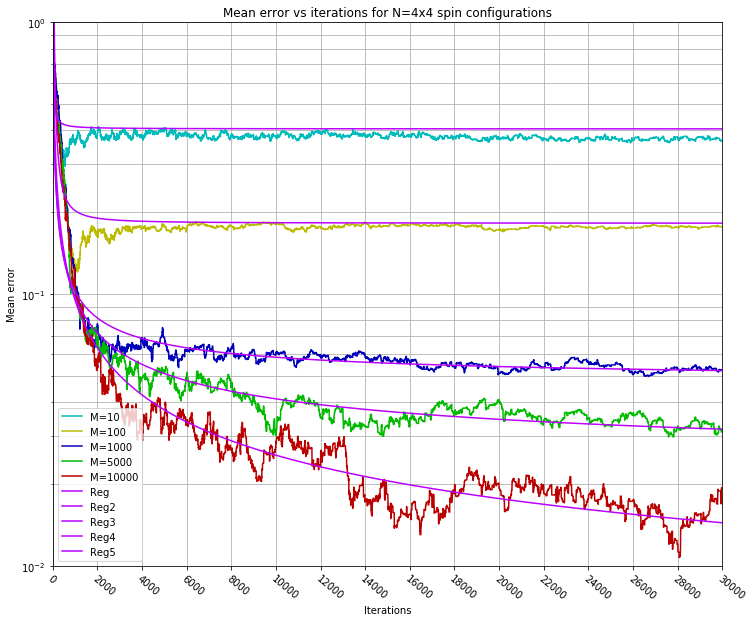

In [196]:
x = np.arange(len(result10[1]))


plt.figure(figsize = (12, 10))
ax = plt.axes()
plt.title('Mean error vs iterations for N=4x4 spin configurations')
plt.xlabel('Iterations')
plt.ylabel('Mean error')
plt.plot(x, result10[1], color='#00bbbb', label='M=10')
plt.plot(x, result100[1], color='#bbbb00', label='M=100')
plt.plot(x, result1000[1], color='#0000bb', label='M=1000')
plt.plot(x, result5000[1], color='#00bb00', label='M=5000')
plt.plot(x, result10000[1], color='#bb0000', label='M=10000')
plt.plot(x, np.array([6.13888292756698*i**(-0.60717028)+0.00267 for i in x+1]), color='#bb00ff', label='Reg')
plt.plot(x, np.array([4.37645612166665*i**(-0.58711038)+0.02155 for i in x+1]), color='#bb00ff', label='Reg2')
plt.plot(x, np.array([5.70561176349234*i**(-0.66964501)+0.0466 for i in x+1]), color='#bb00ff', label='Reg3')
plt.plot(x, np.array([254.933132385748*i**(-1.36298925)+0.1822 for i in x+1]), color='#bb00ff', label='Reg4')
plt.plot(x, np.array([9.58454948814573*i**(-1.03037537)+0.4052 for i in x+1]), color='#bb00ff', label='Reg5')
plt.yscale('log')
plt.ylim(1e-2, 1)
plt.xlim(0, np.max(x))
plt.xticks(range(0, np.max(x) + 2, 2000))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-40, ha="left", rotation_mode="anchor")
plt.grid(True, which='both')
plt.legend()
plt.savefig('error_L4_s1_T1_30000it_4.png')
plt.show()


0.00267
coefficient of determination: 0.9117662763427136
intercept: 1.8146427919861194
slope: [-0.60717028]


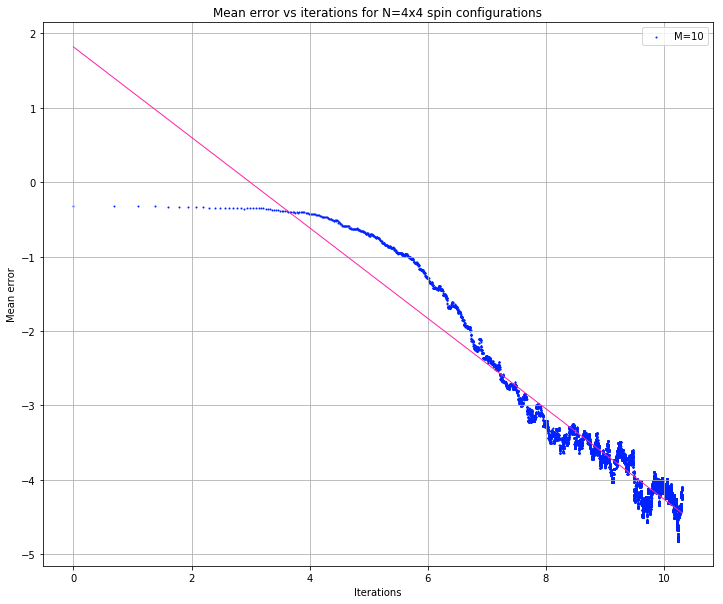

In [187]:
from sklearn.linear_model import LinearRegression
x = np.arange(len(result10000[2])) + 1
r = 0
dif = 0
for i in tqdm_notebook(np.arange(0.0, 0.05, 0.00001)):
    test = np.array(result10000[1]) - i
    x = np.arange(len(result10000[2])) + 1
    x = x[test>0]
    test = test[test>0]
    fit_y = np.log(test)
    fit_x = np.log(x)
    model = LinearRegression().fit(fit_x.reshape((-1,1)), fit_y)
    r_sq = model.score(fit_x.reshape((-1,1)), fit_y)
    if r_sq > r:
        r = r_sq
        dif = i

test = np.array(result10000[1]) - dif
x = np.arange(len(result10000[2])) + 1
x = x[test>0]
test = test[test>0]
fit_y = np.log(test)
fit_x = np.log(x)
model = LinearRegression().fit(fit_x.reshape((-1,1)), fit_y)
r_sq = model.score(fit_x.reshape((-1,1)), fit_y)
print(dif)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

plt.figure(figsize = (12, 10))
ax = plt.axes()
plt.title('Mean error vs iterations for N=4x4 spin configurations')
plt.xlabel('Iterations')
plt.ylabel('Mean error')
plt.scatter(fit_x, fit_y, color='#0022ff', label='M=10', s=1)
plt.plot((np.min(fit_x), np.max(fit_x)), (model.predict(np.array([np.min(fit_x)]).reshape((-1,1))), model.predict(np.array([np.max(fit_x)]).reshape((-1,1)))), color='#ff22aa', linestyle = '-', linewidth = 1)
#plt.yscale('log')
#plt.ylim(1e-2, 1)
#plt.xlim(0, np.max(fit_x))
#plt.xticks(range(0, np.max(x) + 2, 2000))
#plt.setp( ax.xaxis.get_majorticklabels(), rotation=-40, ha="left", rotation_mode="anchor")
plt.grid(True, which='both')
plt.legend()
#plt.savefig('error_L4_s1_T1_30000it_4.png')
plt.show()

In [12]:
result = simulated_algorithm_min_multi(sample, real_temp=2.0, max_iter=10000, magnetic_field=False)

Time values:  0.0006976239999403333
Time nbrs:  0.007269776999919486
Time log:  0.035928081000065504
Time: start 0.037512469999910536



Time: end 54.53347745199994


In [13]:
#print(result[0][0])
print(result[0][1])
#print(result[0][2])
print(j)

[[ 0.29004546  0.77488751]
 [ 0.65970483 -0.30202926]
 [ 0.82898385 -0.83393862]
 [ 0.46102636 -0.60114131]
 [-0.83020018  0.14356553]
 [ 0.94252144 -0.32661686]
 [-0.30605822 -0.14633063]
 [ 0.28854697 -0.8807189 ]
 [-0.7176665   0.15958866]
 [-0.50230073 -0.27878994]
 [-0.83276256 -0.37438954]
 [-0.23244064 -0.3122508 ]
 [ 0.99839436 -0.27077303]
 [-0.726336    0.07625954]
 [ 0.89168721  0.87343349]
 [-0.15727397 -0.0342646 ]]
[[ 0.0833333  0.5633333]
 [ 0.7633334 -0.79     ]
 [ 0.6266667 -0.4766667]
 [ 0.63      -0.63     ]
 [-0.5166667  0.2666667]
 [ 0.7066667 -0.31     ]
 [ 0.0133333 -0.2266667]
 [ 0.3866667 -0.7033334]
 [-0.4166667  0.39     ]
 [-0.5866667 -0.3766667]
 [-0.48      -0.0566667]
 [-0.25      -0.28     ]
 [ 0.9966667 -0.1166667]
 [-0.8433334 -0.05     ]
 [ 0.7        0.7466667]
 [-0.2233333 -0.1866667]]


In [14]:
print(np.mean(abs(result[0][1] - j)))

0.17192443631553878


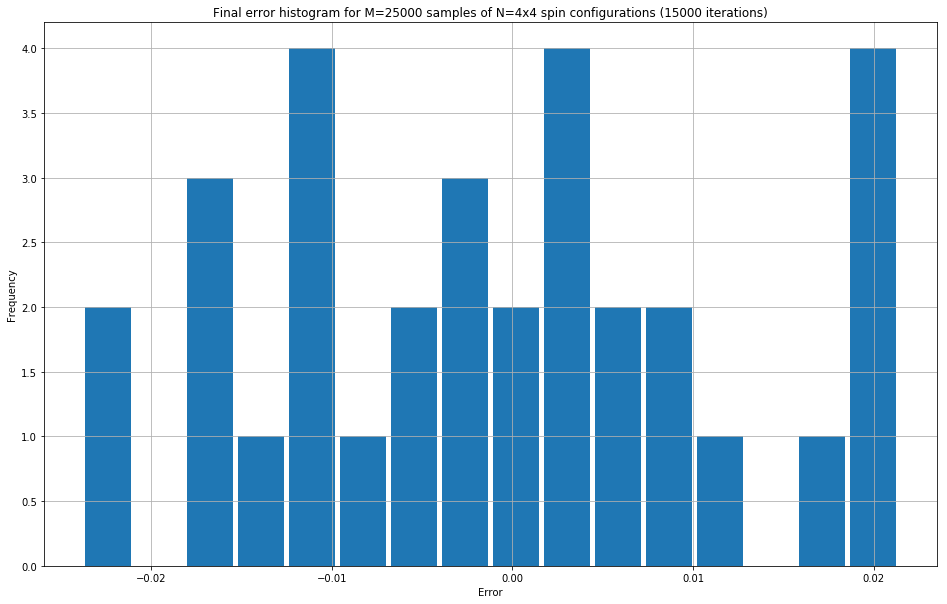

In [220]:
errors = (result[0][1] - j).flatten()
plt.figure(figsize = (16, 10))
ax = plt.axes()
plt.title('Final error histogram for M=25000 samples of N=4x4 spin configurations (15000 iterations)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.hist(errors, bins=16, rwidth=0.9)
#plt.xlim(-0.07, 0.07)
#plt.xticks(np.arange(-0.07, 0.071, 0.01))
plt.grid()
plt.savefig('error_hist_L4_s3_T3_15000it_1.png')
plt.show()

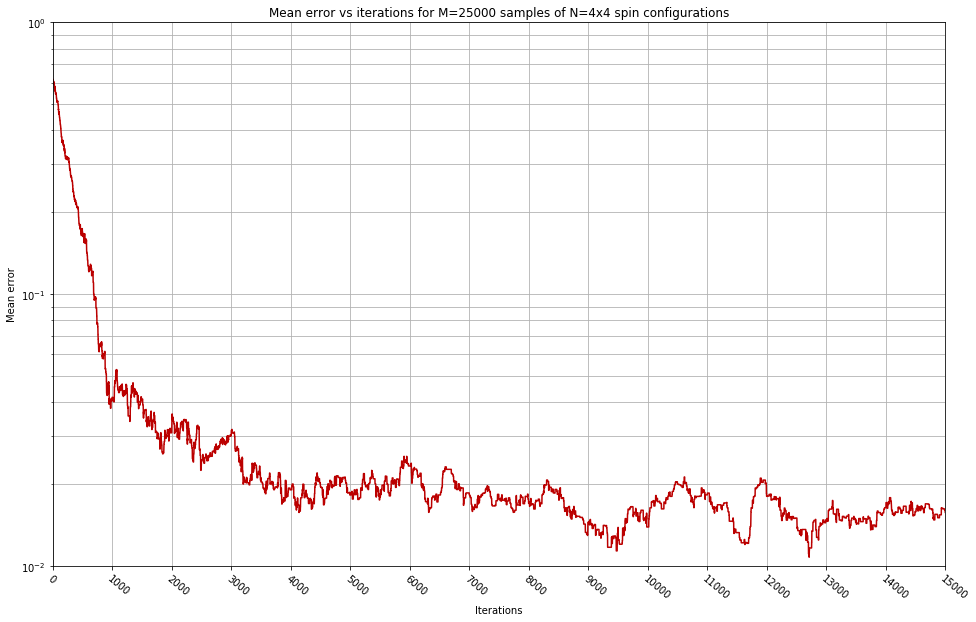

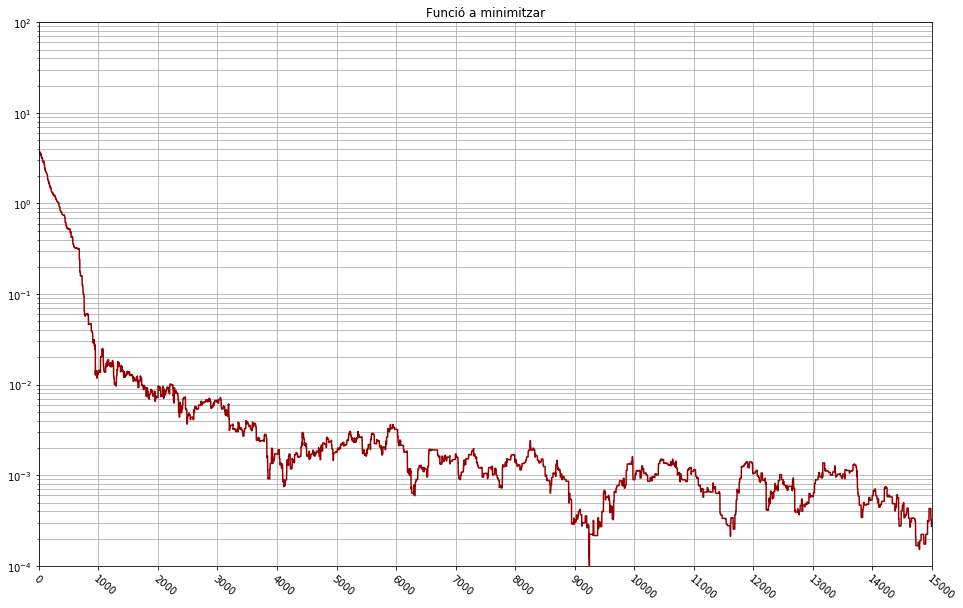

In [221]:
x = np.arange(len(result[1]))


plt.figure(figsize = (16, 10))
ax = plt.axes()
plt.title('Mean error vs iterations for M=25000 samples of N=4x4 spin configurations')
plt.xlabel('Iterations')
plt.ylabel('Mean error')
plt.plot(x, result[1], color='#bb0000')
plt.yscale('log')
plt.ylim(1e-2, 1)
plt.xlim(0, np.max(x))
plt.xticks(range(0, np.max(x) + 2, 1000))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-40, ha="left", rotation_mode="anchor")
plt.grid(True, which='both')
plt.savefig('error_L4_s3_T3_15000it_1.png')
plt.show()

x = np.arange(len(result[2]))
y = result[2] - np.min(result[2]) + 0.0001


plt.figure(figsize = (16, 10))
ax = plt.axes()
plt.title('Funció a minimitzar')
plt.plot(x, y, color='#960000')
plt.yscale('log')
plt.ylim(0.0001, 100)
plt.xlim(0, np.max(x))
plt.xticks(range(0, np.max(x) + 2, 1000))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-40, ha="left", rotation_mode="anchor")
plt.grid(True, which='both')
plt.show()